In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
from visualizer import * 

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 8  # numer of node visits in a trajectory
num_desired_trajectories= 30

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

# env = GraphEnv( n_items=n_nodes,                     # number of possible observations
#                 env='tree', 
#                 batch_size=trajectory_length, 
#                 num_desired_trajectories=num_desired_trajectories, 
#                 device=None, 
#                 unique=True,                         # each state is assigned a unique observation if true
#                 args = {"levels": 4}
#             )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.gen_dataset()
test_dataset = env.gen_dataset()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

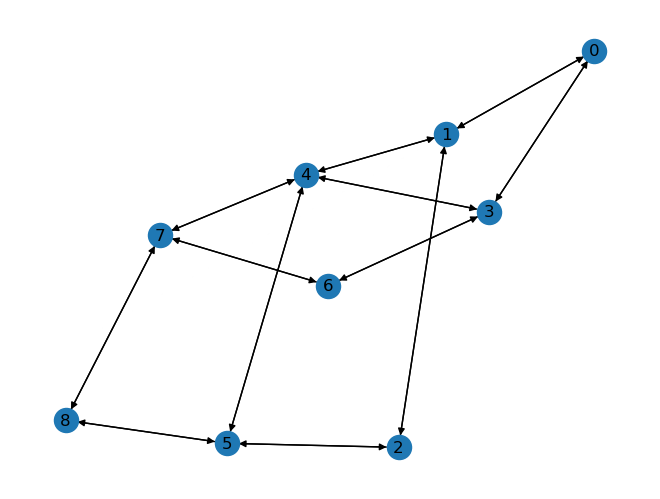

number of actions: 4
Sample trajectory:
tensor([[[7, 0, 4, 7, 4],
         [4, 1, 7, 4, 7],
         [7, 2, 6, 7, 6],
         [6, 0, 3, 6, 3],
         [3, 0, 0, 3, 0],
         [0, 3, 1, 0, 1],
         [1, 1, 4, 1, 4]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
action-to-node:
{1: tensor([5, 8]), 3: tensor([7, 8]), 2: tensor([8, 7]), 0: tensor([8, 5])}
node-to-action-matrix:
tensor([[-1,  3, -1,  1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1,  1, -1, -1, -1, -1],
        [-1,  2, -1, -1, -1,  1, -1, -1, -1],
        [ 0, -1, -1, -1,  3, -1,  1, -1, -1],
        [-1,  0, -1,  2, -1,  3, -1,  1, -1],
        [-1, -1,  0, -1,  2, -1, -1, -1,  1],
        [-1, -1, -1,  0, -1, -1, -1,  3, -1],
        [-1, -1, -1, -1,  0, -1,  2, -1,  3],
        [-1, -1, -1, -1, -1,  0, -1,  2, -1]])
affordance / node - to action:
{0: tensor([1, 3]), 1: tensor([1, 2, 3]), 2: tensor([1, 2]), 3: tensor([0, 1, 3]), 4: tensor([0, 1, 2, 3]), 5: tensor([0, 1, 2]), 6: tensor([0, 3]), 7: tensor([0, 2,

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 70 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [ ]:
# Our code
from trainer import POCMLTrainer
from model import POCML, sim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 20
random_feature_dim = 500
epochs = 10

model = POCML(
    n_obs = env.n_items,
    n_states = env.size,
    n_actions = env.n_actions,
    state_dim = state_dim,
    random_feature_dim = random_feature_dim,
    alpha = 4,
    memory_bypass=False,
)
    
trainer = POCMLTrainer(
    model=model, 
    train_loader = train_dataloader,
    lr_Q = 0.1, 
    lr_V = 0.08, 
    lr_all = 0.5,
    normalize = False,
    reset_every=10,
    update_state_given_obs=True,
    debug=True
)

loss_record, best_model = trainer.train(epochs)
model = best_model

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

===========Epoch 0===========
Current Trajectory tensor([[0, 3, 1, 0, 1],
        [1, 2, 0, 1, 0],
        [0, 1, 3, 0, 3],
        [3, 0, 0, 3, 0],
        [0, 1, 3, 0, 3],
        [3, 1, 6, 3, 6],
        [6, 3, 7, 6, 7]])
Action similarities
 tensor([[ 0.4363, -0.1878, -0.0164, -0.1513],
        [-0.1878,  0.9004, -0.0698,  0.3473],
        [-0.0164, -0.0698,  1.2678, -0.0088],
        [-0.1513,  0.3473, -0.0088,  0.8368]])
State kernel similarities (want close to identitiy)
 tensor([[1.0000, 0.9972, 0.9962, 0.9949, 0.9961, 0.9968, 0.9968, 0.9973, 0.9961],
        [0.9972, 1.0000, 0.9966, 0.9979, 0.9979, 0.9966, 0.9989, 0.9973, 0.9979],
        [0.9962, 0.9966, 1.0000, 0.9951, 0.9946, 0.9970, 0.9960, 0.9958, 0.9955],
        [0.9949, 0.9979, 0.9951, 1.0000, 0.9952, 0.9943, 0.9967, 0.9957, 0.9958],
        [0.9961, 0.9979, 0.9946, 0.9952, 1.0000, 0.9967, 0.9973, 0.9975, 0.9979],
        [0.9968, 0.9966, 0.9970, 0.9943, 0.9967, 1.0000, 0.9956, 0.9964, 0.9964],
        [0.9968, 0.9989,

Epochs:   2%|▏         | 1/50 [00:02<01:54,  2.33s/it]

Time 2
o_pre, o_next tensor(4) tensor(3)
Expected previous state tensor([1.0271e-04, 1.1136e-05, 8.5899e-04, 1.2331e-04, 9.9743e-01, 1.2618e-03,
        9.4910e-05, 3.0355e-07, 1.1329e-04])
Expected next state tensor([3.6173e-03, 2.4869e-06, 2.4869e-06, 8.0892e-01, 1.1092e-01, 2.4869e-06,
        2.9885e-03, 2.4869e-06, 7.3544e-02])
Expected next state given obs tensor([8.0754e-07, 2.1036e-08, 2.1178e-08, 9.9996e-01, 2.4103e-05, 2.1081e-08,
        6.4282e-07, 2.1185e-08, 1.5134e-05])
Predicted obs from action tensor([3.6907e-03, 7.0090e-05, 7.0523e-05, 8.0849e-01, 1.1091e-01, 7.1360e-05,
        3.0560e-03, 7.3322e-05, 7.3572e-02])
Gamma tensor([[-1.1029e-01, -2.3832e-01, -5.0805e-02, -2.4864e-06, -3.3657e-03,
         -1.6037e-01, -8.6923e-02, -2.4864e-06, -2.4864e-06],
        [-2.4659e-06, -1.0938e-01, -1.5741e+00, -2.4659e-06, -2.4659e-06,
         -2.5099e-02, -2.4659e-06, -6.5237e-02, -2.4659e-06],
        [-2.4657e-06, -5.5824e-02, -1.0937e-01, -2.4657e-06, -2.4657e-06,
       

Epochs:   2%|▏         | 1/50 [00:04<03:29,  4.27s/it]

Time 4
o_pre, o_next tensor(7) tensor(6)
Expected previous state tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Expected next state tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Expected next state given obs tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Predicted obs from action tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Gamma tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan]])
Time 5
o_pre, o_next tensor(6) tensor(7)
Expected previous state tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])
Expected next state te

In [ ]:
print("State differences:\n", model.get_state_differences())
print("Action similarities:\n", model.get_action_similarities())

In [ ]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q, phi_Q))
print("Action kernel similarities:\n", sim(phi_V, phi_V))

In [ ]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model2.ckpt")

In [ ]:
import evaluate

train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

In [ ]:
from sklearn.manifold import * 

In [ ]:
batch_visualize(model.get_state_differences().numpy(), legend = "State", methods = "all", log = False)

In [ ]:
batch_visualize(model.get_action_differences().numpy(), legend = "State", methods = "all", log = False)

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

In [ ]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 